In [1]:
import torch

In [2]:
from torch.utils.data import Dataset
from torchvision.io import read_video

In [3]:
import pandas as pd
from typing import Tuple, Dict, List
import dlib
import numpy as np
from imutils import face_utils
import imutils

In [4]:
# %%writefile modular/utils.py

import os
import dlib
from imutils import face_utils
import imutils
import numpy as np

landmarks_dir = "./landmarks/"

# Path of landmarks model
landmarks_path = os.path.join(landmarks_dir + "/shape_predictor_68_face_landmarks_GTX.dat")

# Create a face detector
face_detector = dlib.get_frontal_face_detector()

# Create a landmark detector
landmark_detector = dlib.shape_predictor(landmarks_path)

def get_landmarks(frame) -> np.ndarray:
    """Takes a frame and generates landmarks for the first face

        Args:
            frame: video frame or image required to generate landmarks
        
        Returns:
            A numpy array containing the co-ordinates of the landmarks of the first face in the given frame
    """
    faces = face_detector(frame)
    landmarks = None
    if faces:
        landmarks = landmark_detector(frame, faces[0])
        landmarks = face_utils.shape_to_np(landmarks)
    return landmarks

def generate_video_landmarks(frames) -> np.ndarray:
    """Generate landmarks the given video
    
        Args:
            filename (str): filename specifying the video
    
        Returns:
            A numpy.ndarray containing all the landmarks for the faces in the video"""
    landmarks = []
    for frame in frames:
        landmarks.append(get_landmarks(frame))
    # landmarks = landmarks_interpolation(landmarks)
    return np.array(landmarks)

def landmarks_interpolation(landmarks):
    """Adds the missing landmarks to the landmarks array

    Args:
        landmarks: An array containing all the detected landmarks

    Returns:
        landmarks array filled in with missing landmarks
    """
    # Obtain indices of all the valid landmarks (i.e landmarks not None)
    valid_landmarks_idx = [idx for idx, _ in enumerate(landmarks) if _ is not None]
    
    if not valid_landmarks_idx:
        return

    # For middle parts of the landmarks array
    for idx in range(1, len(valid_landmarks_idx)):
        # If the valid landmarks indices are adjacent then skip to next iteration
        if valid_landmarks_idx[idx]-valid_landmarks_idx[idx-1] > 1:
            landmarks = linear_interpolation(start_idx=valid_landmarks_idx[idx-1],
                                            end_idx=valid_landmarks_idx[idx],
                                            landmarks=landmarks)

    # For beginning and ending parts of the landmarks array
    valid_landmarks_idx = [idx for idx, _ in enumerate(landmarks) if _ is not None]
    landmarks[:valid_landmarks_idx[0]] = [landmarks[valid_landmarks_idx[0]]] * valid_landmarks_idx[0]
    landmarks[valid_landmarks_idx[-1]:] = [landmarks[valid_landmarks_idx[-1]]] * (len(landmarks) - valid_landmarks_idx[-1])

    return landmarks

def linear_interpolation(start_idx: int, end_idx: int, landmarks):
    """Defines a linear interpolation function to interpolate missing landmarks between indices

    Args:
        start_idx (int): An integer defining the starting index
        end_idx (int): An integer defining the stopping index
        landmarks: An array of size 68 containing the (x,y) values of the facial landmarks

    Returns:
        landmarks array after the missing points have been interpolated.
    """
    start_landmarks = landmarks[start_idx]
    end_landmarks = landmarks[end_idx]
    delta_idx = end_idx - start_idx
    delta_landmarks = end_landmarks - start_landmarks

    # Apply linear interpolation formula
    for idx in range(1, delta_idx):
        landmarks[idx + start_idx] = start_landmarks + delta_landmarks/delta_idx * idx
    return landmarks

def find_classes(dataframe: pd.DataFrame) -> Tuple[List, Dict[str, int]]:
    class_names = dataframe['label'].unique()
    class_to_idx = {label: idx for idx, label in enumerate(class_names)}
    return class_names, class_to_idx

In [5]:
import os
from torchvision.io import read_video

class VideoDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, transform=None, landmarks_dir: str ="landmarks"):
        self.dataframe = dataframe
        self.transform = transform
        self.class_names, self.class_to_idx = find_classes(dataframe)
       
    def __len__(self) -> int:
        """Returns total number of paths in dataframe"""
        return len(self.dataframe)
        
    def __getitem__(self, idx):
        path = self.dataframe.iloc[idx]['path']
        frames,_,_ = read_video(filename=str(path), pts_unit='sec', output_format='TCHW')
        landmarks = generate_video_landmarks(frames.permute(0,2,3,1).numpy())

        if landmarks is None:
            return None
        
        class_name = self.dataframe.iloc[idx]['label']
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            frames = self.transform(frames, landmarks)
        return frames,class_idx

## Transforms

In [6]:
import torch
from torch import nn
import cv2
import numpy as np

from typing import Tuple

class WarpAffine(nn.Module):
    def __init__(self, mean_landmarks_path: str):
        super().__init__()
        self.mean_landmarks = np.load(mean_landmarks_path)
        self.stable_points=(28, 33, 36, 39, 42, 45, 48, 54)
        self.reference_landmarks = np.vstack([self.mean_landmarks[x] for x in self.stable_points])

    def get_transform(self, src_points: np.ndarray) -> np.ndarray:
        transform, _ = cv2.estimateAffinePartial2D(src_points, self.reference_landmarks, method=cv2.LMEDS)
        return transform
        
    
    def forward(self, frames, landmarks_list):
        warped_frames = []
        transformed_landmarks_list = []
        for i, landmarks in enumerate(landmarks_list):
            # Extract only stable points from current landmarks
            stable_points_landmarks = np.vstack([landmarks[x] for x in self.stable_points])
    
            # Calculate affine transformation matrix
            transform_matrix = self.get_transform(stable_points_landmarks)
    
            # Apply affine transformation to each frame
            h, w = frames[i].shape[1:]
            warped_frame = cv2.warpAffine(frames[i].squeeze().numpy(), transform_matrix, dsize=(256,256))
            transformed_landmarks = np.matmul(landmarks, transform_matrix[:, :2].transpose()) + transform_matrix[:,2].transpose() 
    
            warped_frames.append(warped_frame)
            transformed_landmarks_list.append(transformed_landmarks)

        return np.array(warped_frames), np.array(transformed_landmarks_list)

In [7]:
class SmoothLandmarks(nn.Module):
    def __init__(self):
        super().__init__()
        self.temporal_window = 6
        
    def forward(self, frames, landmarks_list, smoothed_landmarks_list=None):
        if smoothed_landmarks_list is None:
            smoothed_landmarks_list = []
        for idx, landmarks in enumerate(landmarks_list):
            window_margin = min(self.temporal_window, idx, len(landmarks_list) - 1 - idx)
            smoothed_landmarks = np.mean([landmarks_list[x] for x in range(idx - window_margin, idx + window_margin + 1)], axis=0)
            smoothed_landmarks += landmarks_list[idx].mean(axis=0) - smoothed_landmarks.mean(axis=0)
            smoothed_landmarks_list.append(smoothed_landmarks)
            
        return frames, np.array(smoothed_landmarks_list)

In [8]:
class CropPatch(nn.Module):
    def __init__(self):
        super().__init__()
        self.crop_height = 96
        self.crop_width = 96
        self.start_idx, self.end_idx = 48,68
    
    def forward(self, frames, landmarks_list):
        cropped_landmarks = landmarks_list[:, self.start_idx:self.end_idx, :]
        center = np.round(np.mean(cropped_landmarks, axis=1))
        center_x, center_y = center[:,0].astype(int), center[:,1].astype(int)

        mouth_roi = np.zeros((len(frames), self.crop_height, self.crop_width))

        for i, frame in enumerate(frames):
            mouth_roi[i] = frame[center_y[i]-self.crop_height//2:self.crop_height//2+center_y[i], center_x[i]-self.crop_width//2 : self.crop_width//2+center_x[i]]
        
        return torch.tensor(mouth_roi, dtype=torch.float32)

In [9]:
from torchvision.transforms import v2
from torchvision.transforms import ToTensor

data_transforms = v2.Compose([
    v2.Grayscale(),
    v2.Resize(size=(256,256), antialias=False),
    SmoothLandmarks(),
    WarpAffine(mean_landmarks_path="mean_landmarks/20words_mean_face.npy"),
    CropPatch(),
])
train_data = VideoDataset(dataframe=pd.read_pickle("dataframe/train_df_3.pkl"), transform=data_transforms)
test_data = VideoDataset(dataframe=pd.read_pickle("dataframe/test_df_3.pkl"), transform=data_transforms)
val_data = VideoDataset(dataframe=pd.read_pickle("dataframe/val_df_3.pkl"), transform=data_transforms)

## Testing Transforms

In [10]:
from torchvision.transforms import v2

transform_test = v2.Compose([
    v2.Grayscale(),
    v2.Resize(size=(256,256), antialias=False),
    SmoothLandmarks(),
    WarpAffine(mean_landmarks_path="mean_landmarks/20words_mean_face.npy"),
    CropPatch(),
    # v2.ToDtype(torch.float32),
    # ToTensor(),
])

In [11]:
frames, landmarks,class_idx = train_data[275803]

IndexError: single positional indexer is out-of-bounds

In [ ]:
transformed = transform_test(frames, landmarks)
type(transformed)
transformed.dtype
# center.shape
# print(transformed)

In [ ]:
landmarks.shape

In [ ]:
test_frames, _,_ = read_video("./data/lipread_mp4/ABOUT/train/ABOUT_00002.mp4")

In [ ]:
test_landmarks = generate_video_landmarks(test_frames.numpy())

In [ ]:
test_landmarks.shape

In [ ]:
transformed_landmarks = generate_video_landmarks(transformed.numpy())

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(transformed[20], cmap='gray')
mean_landmarks_np = np.load('mean_landmarks/20words_mean_face.npy')
plt.scatter(mean_landmarks_np[:,0], mean_landmarks_np[:, 1], label="Transformed")
plt.scatter(t_landmarks[20][:,0], t_landmarks[20][:,1], alpha=0.4)
plt.scatter(center[20][0], center[20][1],alpha=1)
plt.subplot(1,3,3)
plt.scatter(test_landmarks[20][:,0], test_landmarks[20][:,1],  label="Original")
plt.imshow(test_frames[20], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(transformed[20], cmap='gray')
plt.scatter(transformed_landmarks[20][:,0], transformed_landmarks[20][:,1])
plt.scatter(t_landmarks[20][:,0], t_landmarks[20][:,1])

In [ ]:
frames, _,_ = train_data[275803]

test_frames, _,_ = read_video("./data/lipread_mp4/ABOUT/train/ABOUT_00002.mp4")

In [ ]:
plt.subplot(1,2,1)
plt.imshow(frames[20])
plt.subplot(1,2,2)
plt.imshow(test_frames[20].numpy())

## DataLoaders

In [10]:
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
import os

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 64

def my_collate(batch):
    len_batch = len(batch) # original batch length
    batch = list(filter (lambda x:x is not None, batch)) # filter out all the Nones
    if len_batch > len(batch): # source all the required samples from the original dataset at random
        diff = len_batch - len(batch)
        for i in range(diff):
            batch.append(dataset[np.random.randint(0, len(dataset))])

    return torch.utils.data.dataloader.default_collate(batch)

train_dataloader = DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=True,
                             pin_memory=True,
                             collate_fn=my_collate)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False,
                             pin_memory=True,
                            collate_fn=my_collate)
val_dataloader = DataLoader(dataset=val_data,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            shuffle=False,
                            pin_memory=True,
                           collate_fn=my_collate)

## Device Agnostic Code

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Train and Validation Steps

In [12]:
from tqdm import tqdm

def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device=device):

    model.train()
    train_loss = 0
    train_acc = 0
    
    for batch,(X,y) in enumerate(dataloader):
        if batch % 20 == 0:
            print(batch/len(dataloader) * 100)
        X,y = X.to(device), y.to(device)

        # Optimizer zero grad
        optimizer.zero_grad()

        # Forward pass
        y_logits = model(X)

        # Calculate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()

        # Back Propagation
        loss.backward()

        # Optimizer Step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_logits)

    train_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)
    return train_loss, train_acc

In [13]:
def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device=device):

    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
    
            # Forward pass
            y_logits = model(X)
    
            # Calculate loss
            loss = loss_fn(y_logits, y)
            val_loss += loss

            # Calculate and accumulate accuracy
            val_labels = y_logits.argmax(dim=1)
            val_acc += ((val_labels == y).sum().item()/len(val_labels))

    val_loss = val_loss/len(dataloader)
    val_acc = val_acc/len(dataloader)
    return val_loss, val_acc

In [14]:
def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         val_dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         epochs: int = 32,
         device: torch.device = device):

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)
        val_loss, val_acc = val_step(model=model,
                           dataloader=val_dataloader,
                           loss_fn=loss_fn,
                           device=device)

        print(f"Epoch: {epoch} | Train Loss: {train_loss:.2f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc:.2f}%")

## Baseline Model Creation

In [15]:
class BaselineNonLinearModel(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [16]:
class_names = train_data.class_names
len(class_names)

3

In [17]:
baseline_model = BaselineNonLinearModel(input_shape=29*96*96, hidden_units=128, output_shape=len(class_names)).to(device)

In [18]:
# Loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=baseline_model.parameters(), lr=0.001)

In [19]:
%%time

NUM_EPOCHS = 2

train(model=baseline_model,
     train_dataloader=train_dataloader,
     val_dataloader=val_dataloader,
     loss_fn=loss_fn,
     optimizer=optimizer,
     device=device,
     epochs=NUM_EPOCHS)

  0%|                                                                                                                                                                                     | 0/2 [00:00<?, ?it/s]

0.0


  0%|                                                                                                                                                                                     | 0/2 [00:45<?, ?it/s]


KeyboardInterrupt: 

In [8]:
%%time
test_frames, _,_ = read_video("./data/lipread_mp4/ABOUT/train/ABOUT_00002.mp4")

generate_video_landmarks(test_frames.numpy())

CPU times: user 253 ms, sys: 0 ns, total: 253 ms
Wall time: 253 ms


array([[[ 69,  78],
        [ 68,  95],
        [ 69, 114],
        ...,
        [139, 159],
        [132, 159],
        [125, 157]],

       [[ 68,  85],
        [ 67, 102],
        [ 68, 120],
        ...,
        [140, 159],
        [133, 159],
        [127, 158]],

       [[ 68,  71],
        [ 67,  90],
        [ 66, 109],
        ...,
        [138, 158],
        [130, 159],
        [123, 157]],

       ...,

       [[ 81,  55],
        [ 75,  74],
        [ 69,  93],
        ...,
        [134, 161],
        [127, 159],
        [121, 154]],

       [[ 83,  54],
        [ 77,  73],
        [ 71,  92],
        ...,
        [136, 161],
        [128, 159],
        [121, 155]],

       [[ 82,  56],
        [ 76,  75],
        [ 71,  94],
        ...,
        [136, 161],
        [129, 160],
        [122, 156]]])

In [6]:
import matplotlib.pyplot as plt

def plot_loss_curves(results, epochs=20):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title('Accuracy')
    plt.plot(range(epochs), results['train_acc'], label='Train')
    plt.plot(range(epochs), results['val_acc'], label='Val')
    plt.xlabel('Epochs')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.title('Loss')
    plt.plot(range(epochs), results['train_loss'], label='Train')
    plt.plot(range(epochs), results['val_loss'], label='Val')
    plt.xlabel('Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

In [9]:
import numpy as np

In [10]:
results = np.load('results/LipNet.npz', allow_pickle=True)

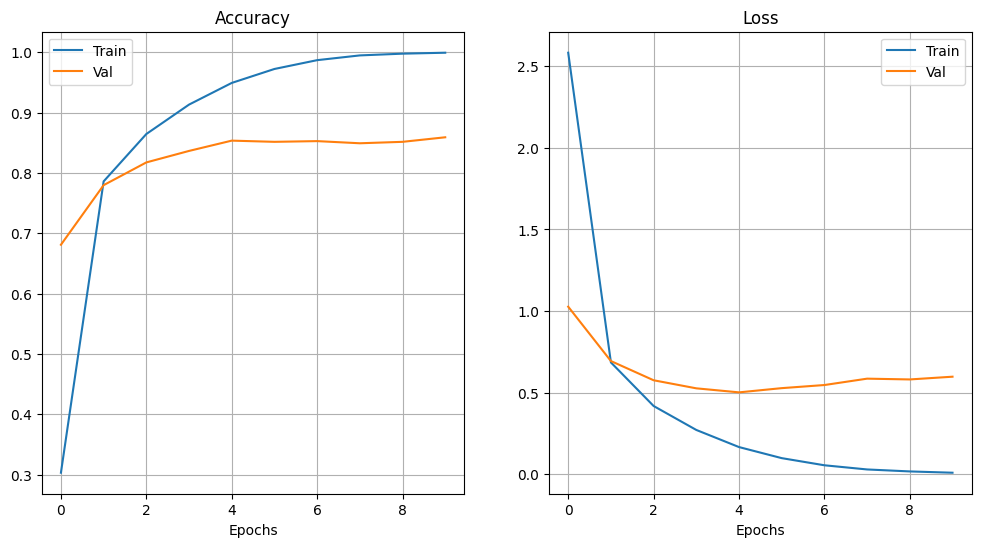

In [32]:
plot_loss_curves(results['arr'].item(), epochs=10)

In [15]:
import pandas as pd
pd.DataFrame(results['arr'].item())

,model_name,train_loss,train_acc,val_loss,val_acc
0,LipNet_GRU,3.910567,0.025923,3.884078,0.037184
1,LipNet_GRU,3.883301,0.032495,3.854674,0.041535
2,LipNet_GRU,3.862714,0.037373,3.839651,0.039161
3,LipNet_GRU,3.729590,0.054397,3.218619,0.117089
4,LipNet_GRU,2.702785,0.227119,2.150052,0.369858
5,LipNet_GRU,1.806827,0.464647,1.532661,0.540744
6,LipNet_GRU,1.298385,0.607017,1.109876,0.660997
7,LipNet_GRU,1.023209,0.687459,0.934978,0.710047
8,LipNet_GRU,0.861160,0.731323,0.855198,0.728639
9,LipNet_GRU,0.757087,0.762655,0.748064,0.768987


In [11]:
results = results['arr'].item()

In [4]:
results.keys()

dict_keys(['model_name', 'train_loss_batch', 'train_acc_batch', 'val_loss_batch', 'val_acc_batch', 'train_loss_epoch', 'val_loss_epoch', 'train_acc_epoch', 'val_acc_epoch', 'batch_lr', 'max_epoch', 'batch_size', 'train_dataset_len', 'val_dataset_len', 'optimizer_params'])

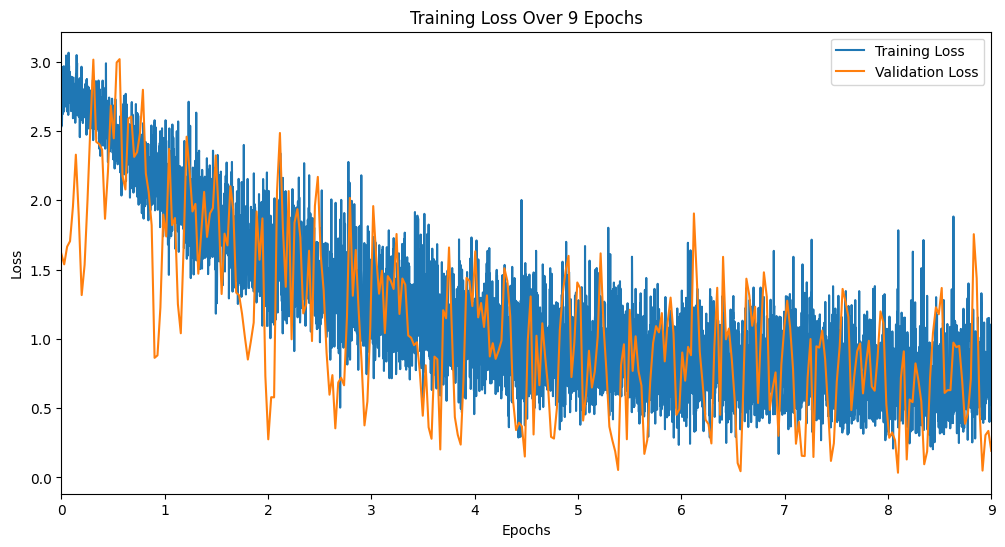

In [12]:
import matplotlib.pyplot as plt

epoch = results['max_epoch']-1
train_loss = results['train_loss_batch']
val_loss = results['val_loss_batch']
train_epoch_space = np.linspace(0, epoch, len(train_loss))
val_epoch_space = np.linspace(0, epoch, len(val_loss))
# Plotting the training loss
plt.figure(figsize=(12, 6))
plt.plot(train_epoch_space, train_loss, label='Training Loss')
plt.plot(val_epoch_space, val_loss, label='Validation Loss')
plt.title(f'Training Loss Over {epoch} Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0,9)
plt.legend()

plt.show()

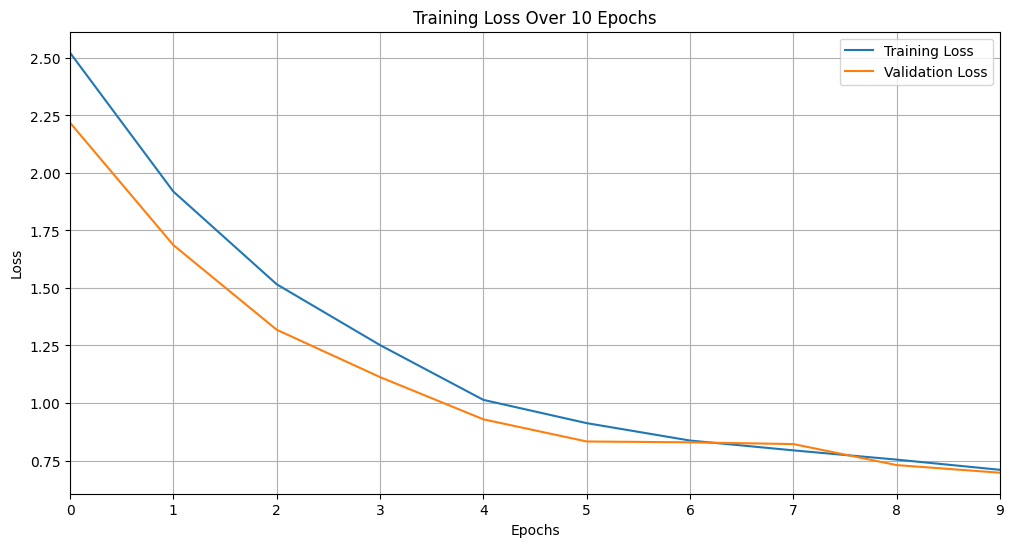

In [13]:
import matplotlib.pyplot as plt

epoch = results['max_epoch']-1
train_loss = results['train_loss_epoch']
val_loss = results['val_loss_epoch']

# Plotting the training loss
plt.figure(figsize=(12, 6))
plt.plot(range(epoch+1), train_loss, label='Training Loss')
plt.plot(range(epoch+1), val_loss, label='Validation Loss')
plt.title(f'Training Loss Over {epoch+1} Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0,epoch)
plt.legend()
plt.grid()

plt.show()

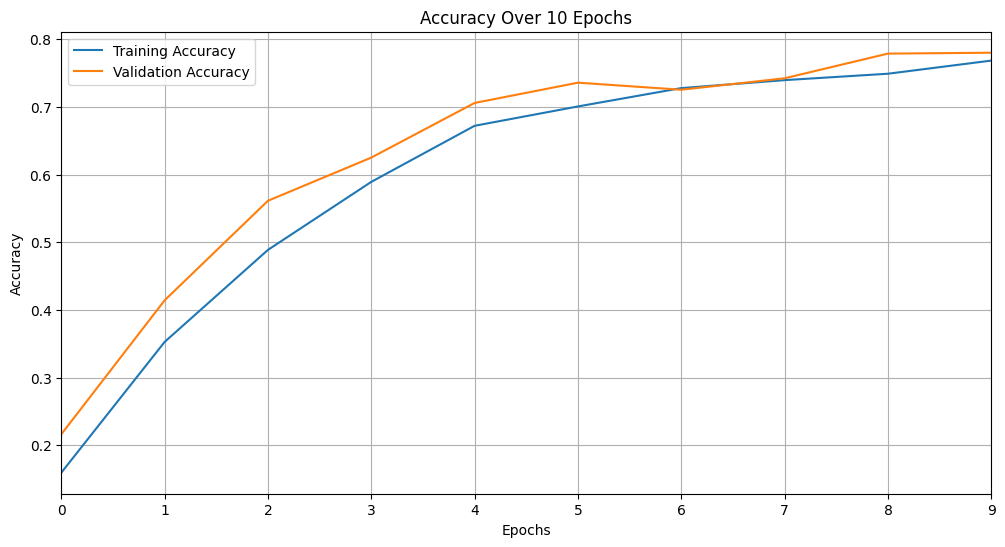

In [14]:
import matplotlib.pyplot as plt

epoch = results['max_epoch']-1
train_loss = results['train_acc_epoch']
val_loss = results['val_acc_epoch']

# Plotting the training loss
plt.figure(figsize=(12, 6))
plt.plot(range(epoch+1), train_loss, label='Training Accuracy')
plt.plot(range(epoch+1), val_loss, label='Validation Accuracy')
plt.title(f'Accuracy Over {epoch+1} Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(0,epoch)
plt.legend()
plt.grid()
plt.show()

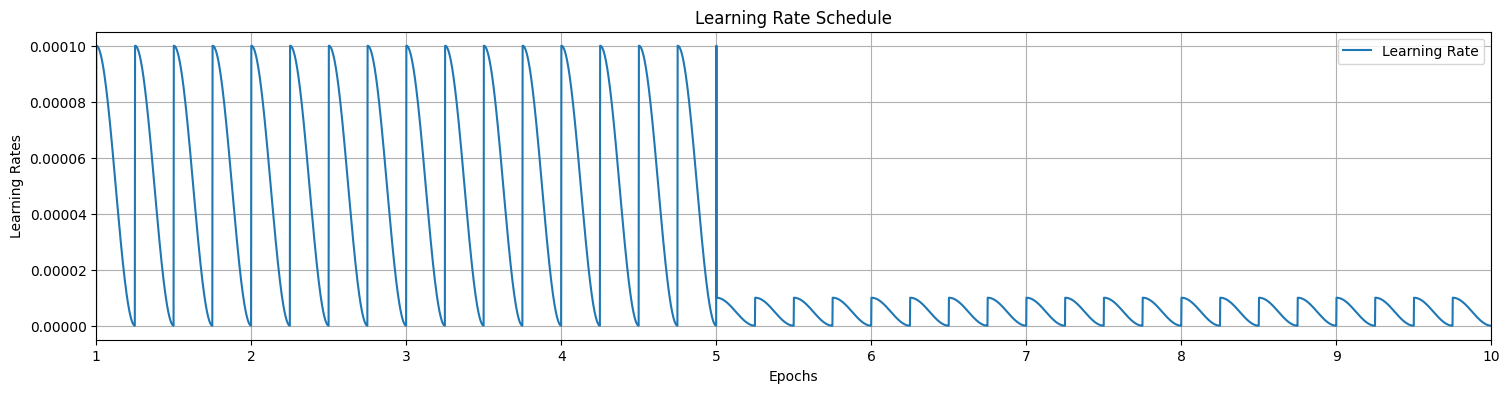

In [46]:
lr_schedules = resnet_results['batch_lr']
lr_epoch_space = np.linspace(0, epochs, 6120)
# Plotting the training loss
plt.figure(figsize=(18, 4))
plt.plot(lr_epoch_space, lr_schedules, label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Learning Rates')
plt.legend()
plt.xlim(1, epochs)
plt.xticks(range(1,epochs+1))
# plt.ylim(0, results['optimizer_params']['lr'])
plt.grid()
plt.savefig('lr_schedule.png')
plt.show()

In [1]:
import numpy as np

resnet_results = np.load('results/custom/ResNet_GRU_custom.npz', allow_pickle=True)['arr'].item()
baseline_results = np.load('results/baseline/LipNet.npz', allow_pickle=True)['arr'].item()

epochs = resnet_results['max_epoch']

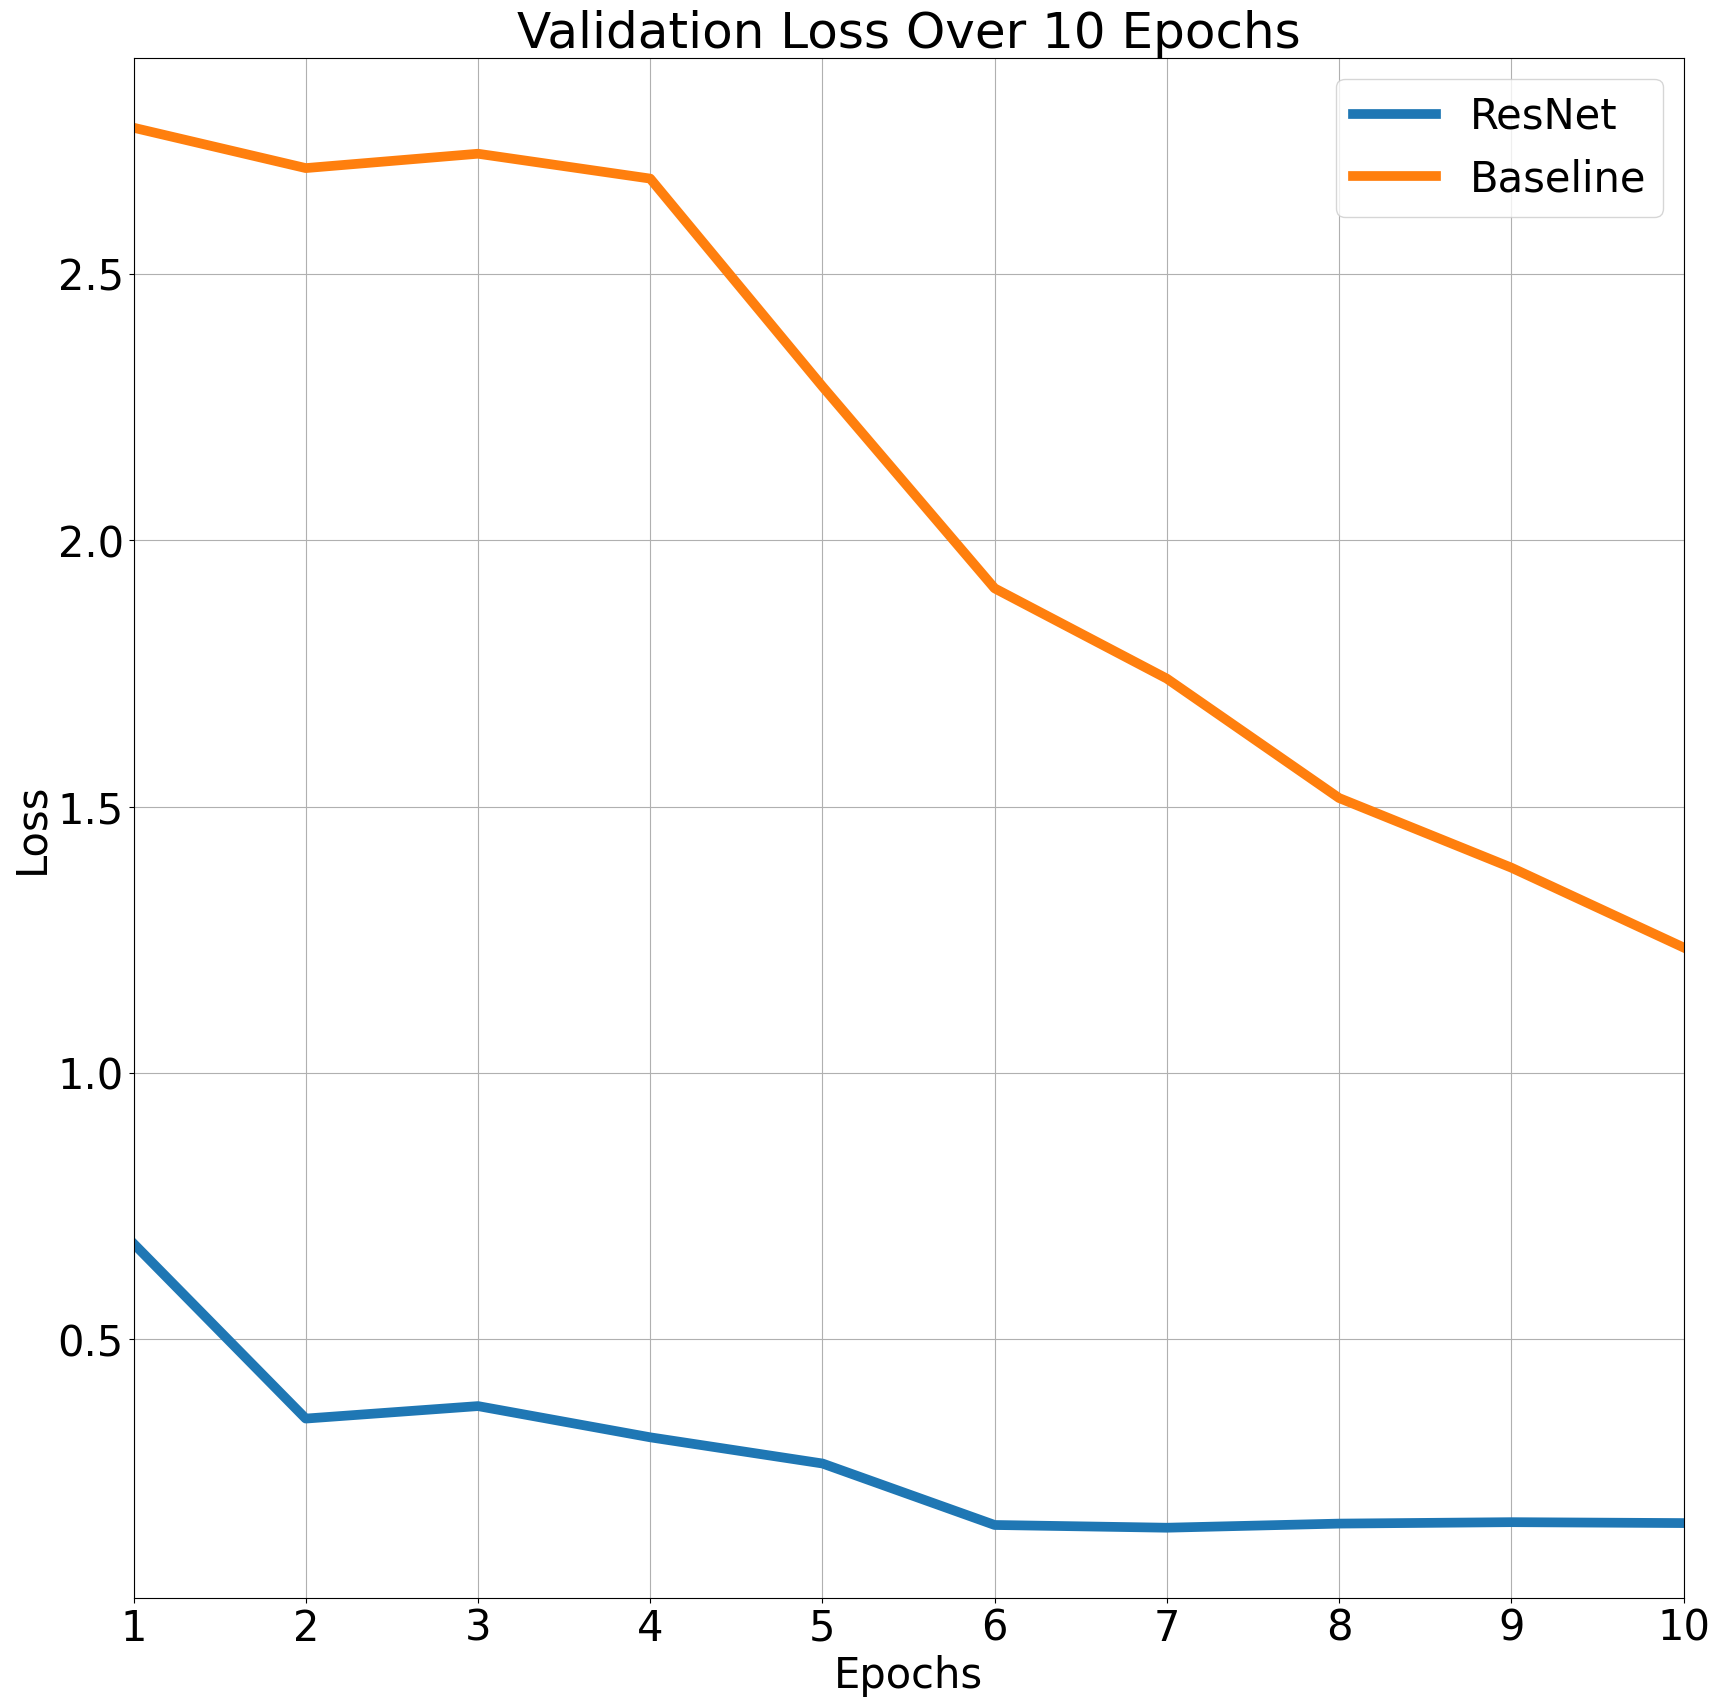

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 30})
# plt.subplot(2,2,1)
plt.plot(range(1,epochs+1), resnet_results['train_loss_epoch'], label='ResNet', linewidth=7)
plt.plot(range(1,epochs+1), baseline_results['train_loss_epoch'], label='Baseline', linewidth=7)
plt.xlim(1,epochs)
# plt.ylim(0, 2.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training Loss Over {epochs} Epochs',)
plt.grid()
plt.legend()

# plt.subplot(2,2,2)
# plt.plot(range(1,epochs+1), resnet_results['val_loss_epoch'], label='ResNet', linewidth=7)
# plt.plot(range(1,epochs+1), baseline_results['val_loss_epoch'], label='Baseline', linewidth=7)
# plt.xlim(1,epochs)
# # plt.ylim(0, 2.5)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title(f'Validation Loss Over {epochs} Epochs')
# plt.grid()
# plt.legend()

# plt.subplot(2,2,3)
# plt.plot(range(1,epochs+1), resnet_results['train_acc_epoch'], label='ResNet',linewidth=7)
# plt.plot(range(1,epochs+1), baseline_results['train_acc_epoch'], label='Baseline',linewidth=7)
# plt.xlim(1,epochs)
# plt.ylim(0, 1.01)
# plt.yticks(np.arange(0,1.1,0.1))
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title(f'Training Accuracy Over {epochs} Epochs')
# plt.grid()
# plt.legend()

# # plt.subplot(2,2,4)
# plt.plot(range(1,epochs+1), resnet_results['val_acc_epoch'], label='ResNet', linewidth=7)
# plt.plot(range(1,epochs+1), baseline_results['val_acc_epoch'], label='Baseline', linewidth=7)
# plt.xlim(1,epochs)
# plt.yticks(np.arange(0,1.1,0.1))
# plt.ylim(0, 1.01)
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title(f'Validation Accuracy Over {epochs} Epochs')
# plt.grid()
# plt.legend()
# plt.savefig('train_acc.png')


plt.savefig('val_loss.png')
plt.show()

In [35]:
np.arange(0,1,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])